In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [4]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)

In [8]:
wine = datasets.load_wine()

In [18]:
wine.data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [20]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     wine.data, wine.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [21]:
sample_train[0]

array([-0.61138269,  0.03448793,  0.4718605 ,  0.70676047])

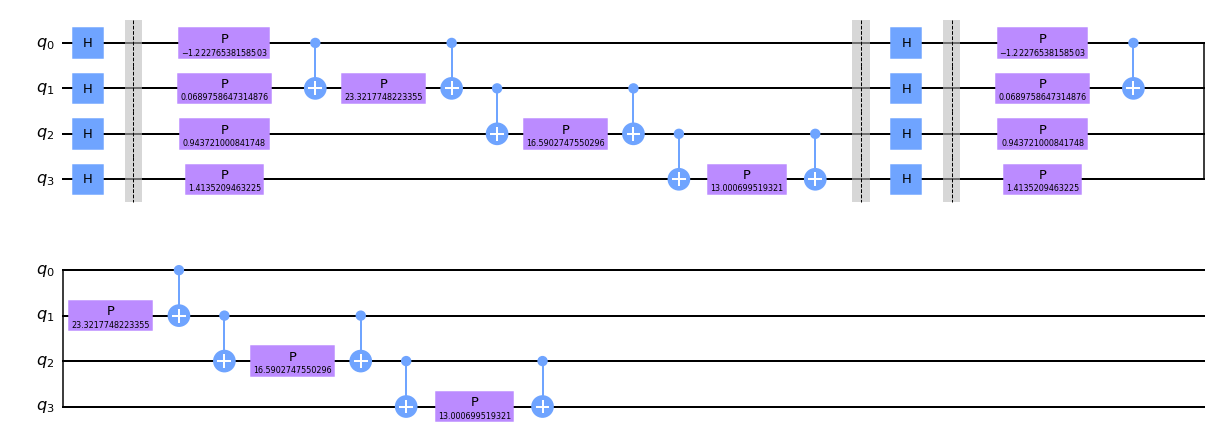

In [23]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

In [24]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

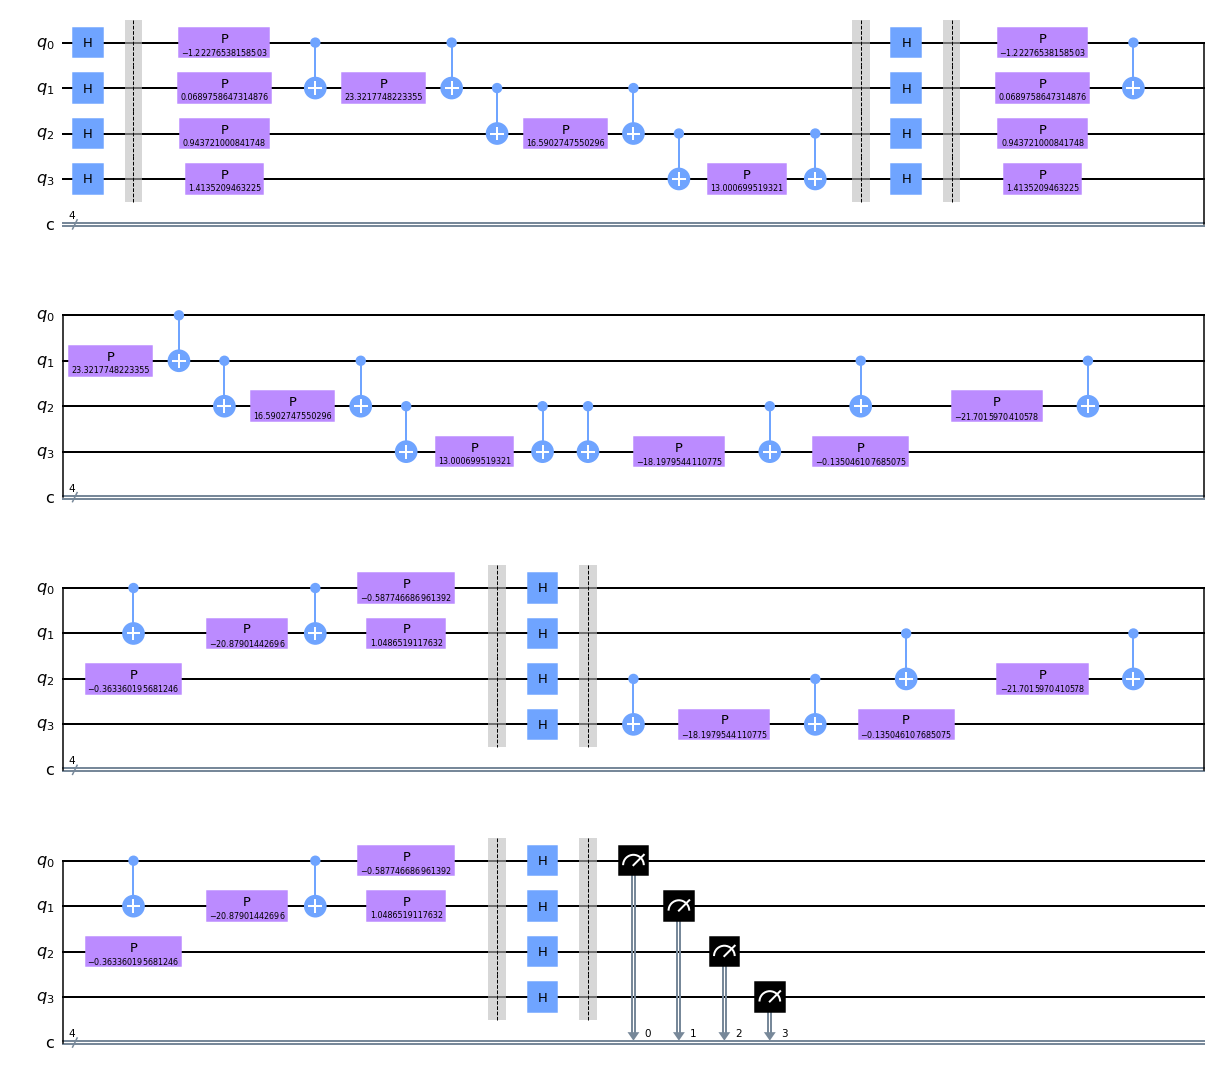

In [27]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

In [28]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

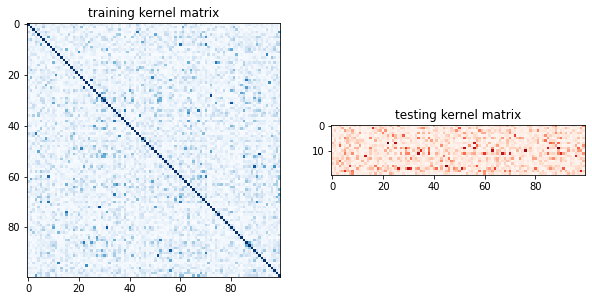

In [29]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [30]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.75


In [31]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.95
poly kernel classification test score:  0.90
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.95
